For this project, we followed the same lab demonstrations presented by Prof. Mark Christenson during the Machine Learning Operations course, Summer 2024, Master of Applied Artificial Intelligence, San Diego University

## Import all the necessary libraries

In [26]:
! pip install dataprep 
! pip install xgboost
! pip install imbalanced-learn
! pip install pyathena

In [27]:
import pandas as pd
from sklearn import preprocessing
from dataprep.eda import create_report, plot_correlation
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn import metrics
from sklearn import tree
import os
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
import boto3
import sagemaker
from pyathena import connect
import time
from time import gmtime, strftime, sleep
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.feature_store.feature_group import FeatureGroup
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
import re
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from time import gmtime, strftime
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

## Data

For this project, we have exploited the dataset “Indicators of Heart Disease (2022 UPDATE)”, which is available on Kaggle (https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease).

## EDA and Data Preparation

In [28]:
# Use the datafiles "heart_2020_cleaned.csv" and "heart_2022_no_nans.csv" from (https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease

df1 = pd.read_csv('heart_2020_cleaned.csv') 
df2 = pd.read_csv('heart_2022_no_nans.csv') 

print('The shape of dataset df1 is', df1.shape, '\n') 

print('The shape of dataset df2 is', df2.shape, '\n') 

print('Features dataset df1:', df1.columns, '\n')
print('Features dataset df2:', df2.columns, '\n')

The shape of dataset df1 is (319795, 18) 

The shape of dataset df2 is (246022, 40) 

Features dataset df1: Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object') 

Features dataset df2: Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthni

In [29]:
# df2 is adjusted based on df1
df2_bis = pd.DataFrame({'HeartDisease': df2.HighRiskLastYear,
                       'BMI': df2.BMI,
                       'Smoking': df2.SmokerStatus,
                       'AlcoholDrinking': df2.AlcoholDrinkers,
                       'Stroke': df2.HadStroke,
                       'PhysicalHealth': df2.PhysicalHealthDays,
                       'MentalHealth': df2.MentalHealthDays,
                       'DiffWalking': df2.DifficultyWalking,
                       'Sex': df2.Sex,
                       'AgeCategory': df2.AgeCategory,
                       'Race': df2.RaceEthnicityCategory,
                       'Diabetic': df2.HadDiabetes,
                       'PhysicalActivity': df2.PhysicalActivities,
                       'GenHealth': df2.GeneralHealth,
                       'SleepTime': df2.SleepHours,
                       'Asthma': df2.HadAsthma,
                       'KidneyDisease': df2.HadKidneyDisease,
                       'SkinCancer': df2.HadSkinCancer})

In [30]:
# Print the first rows of df1 to understand if further adjustments are necessary
print('First rows of df1: \n')
df1

First rows of df1: 



,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No


In [31]:
# Print the first rows of df2_bis to understand if further adjustments are necessary
print('First rows of df2_bis: \n')
df2_bis

First rows of df2_bis: 



,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,27.99,Former smoker,No,No,4.0,0.0,No,Female,Age 65 to 69,"White only, Non-Hispanic",No,Yes,Very good,9.0,No,No,No
1,No,30.13,Former smoker,No,No,0.0,0.0,No,Male,Age 70 to 74,"White only, Non-Hispanic",Yes,Yes,Very good,6.0,No,No,No
2,No,31.66,Former smoker,Yes,No,0.0,0.0,Yes,Male,Age 75 to 79,"White only, Non-Hispanic",No,No,Very good,8.0,No,No,No
3,No,31.32,Never smoked,No,No,5.0,0.0,Yes,Female,Age 80 or older,"White only, Non-Hispanic",No,Yes,Fair,9.0,No,No,Yes
4,No,33.07,Never smoked,No,No,3.0,15.0,No,Female,Age 80 or older,"White only, Non-Hispanic",No,Yes,Good,5.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,No,32.28,Never smoked,Yes,No,0.0,0.0,No,Male,Age 60 to 64,"White only, Non-Hispanic",No,Yes,Very good,6.0,No,No,No
246018,No,24.34,Never smoked,No,No,0.0,7.0,No,Female,Age 25 to 29,"Black only, Non-Hispanic",No,Yes,Fair,7.0,No,No,No
246019,No,29.86,Never smoked,Yes,Yes,0.0,15.0,No,Male,Age 65 to 69,"Multiracial, Non-Hispanic",Yes,Yes,Good,7.0,No,No,No
246020,No,28.66,Never smoked,No,No,2.0,2.0,No,Female,Age 50 to 54,"Black only, Non-Hispanic",No,Yes,Excellent,7.0,No,No,No


In [32]:
# Uniform df1 and df2_bis

# print('Entries of column "Smoking" in df2_bis dataset: \n', df2_bis.Smoking.unique())
df2_bis.loc[df2_bis.Smoking == 'Former smoker', 'Smoking'] = 'No'
df2_bis.loc[df2_bis.Smoking == 'Never smoked', 'Smoking'] = 'No'
df2_bis.loc[df2_bis.Smoking == 'Current smoker - now smokes every day', 'Smoking'] = 'Yes'
df2_bis.loc[df2_bis.Smoking == 'Current smoker - now smokes some days', 'Smoking'] = 'Yes'

# print('Entries of column "AgeCategory" in df2_bis dataset: \n', df2_bis.AgeCategory.unique())
df2_bis.loc[df2_bis.AgeCategory == 'Age 18 to 24', 'AgeCategory'] = '18-24'
df2_bis.loc[df2_bis.AgeCategory == 'Age 25 to 29', 'AgeCategory'] = '25-29'
df2_bis.loc[df2_bis.AgeCategory == 'Age 30 to 34', 'AgeCategory'] = '30-34'
df2_bis.loc[df2_bis.AgeCategory == 'Age 35 to 39', 'AgeCategory'] = '35-39'
df2_bis.loc[df2_bis.AgeCategory == 'Age 40 to 44', 'AgeCategory'] = '40-44'
df2_bis.loc[df2_bis.AgeCategory == 'Age 45 to 49', 'AgeCategory'] = '45-49'
df2_bis.loc[df2_bis.AgeCategory == 'Age 50 to 54', 'AgeCategory'] = '50-54'
df2_bis.loc[df2_bis.AgeCategory == 'Age 55 to 59', 'AgeCategory'] = '55-59'
df2_bis.loc[df2_bis.AgeCategory == 'Age 60 to 64', 'AgeCategory'] = '60-64'
df2_bis.loc[df2_bis.AgeCategory == 'Age 65 to 69', 'AgeCategory'] = '65-69'
df2_bis.loc[df2_bis.AgeCategory == 'Age 70 to 74', 'AgeCategory'] = '70-74'
df2_bis.loc[df2_bis.AgeCategory == 'Age 75 to 79', 'AgeCategory'] = '75-79'
df2_bis.loc[df2_bis.AgeCategory == 'Age 80 or older', 'AgeCategory'] = '80 or older'

# print('Entries of column "Race" in df2_bis dataset: \n', df2_bis.Race.unique())
df2_bis.loc[df2_bis.Race == 'White only, Non-Hispanic', 'Race'] = 'White'
df2_bis.loc[df2_bis.Race == 'Black only, Non-Hispanic', 'Race'] = 'Black'
df2_bis.loc[df2_bis.Race == 'Multiracial, Non-Hispanic', 'Race'] = 'Multiracial'
df2_bis.loc[df2_bis.Race == 'Other race only, Non-Hispanic', 'Race'] = 'Other'
df1.loc[df1.Race == 'Asian', 'Race'] = 'Multiracial'
df1.loc[df1.Race == 'American Indian/Alaskan Native', 'Race'] = 'Multiracial'

In [33]:
# Add a date column to both df1 and df2_bis

df1['Origin'] = list((np.ones(len(df1)) * 2020).astype(int))
df2_bis['Origin'] = list((np.ones(len(df2_bis)) * 2022).astype(int)) 

In [34]:
# Merge df1 and df2_bis

df = pd.concat([df1, df2_bis])

## Feature Engineering

In [35]:
# Convert categorical to numerical features

def cat_to_num(dataset):
    
    # Binary features
    dataset.HeartDisease.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.Smoking.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.AlcoholDrinking.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.Stroke.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.DiffWalking.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.Sex.replace(('Female', 'Male'), (0, 1), inplace = True)
    dataset.PhysicalActivity.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.Asthma.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.KidneyDisease.replace(('No', 'Yes'), (0, 1), inplace = True)
    dataset.SkinCancer.replace(('No', 'Yes'), (0, 1), inplace = True)
    # Not binary features
    label_encoder = preprocessing.LabelEncoder()
    dataset.AgeCategory = label_encoder.fit_transform(dataset.AgeCategory)
    dataset.Race = label_encoder.fit_transform(dataset.Race)
    dataset.Diabetic = label_encoder.fit_transform(dataset.Diabetic)
    dataset.GenHealth = label_encoder.fit_transform(dataset.GenHealth)

    return dataset

df = cat_to_num(df)
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Origin
0,0,16.60,1,0,0,3.0,30.0,0,0,7,4,3,1,4,5.0,1,0,1,2020
1,0,20.34,0,0,1,0.0,0.0,0,0,12,4,0,1,4,7.0,0,0,0,2020
2,0,26.58,1,0,0,20.0,30.0,0,1,9,4,3,1,1,8.0,1,0,0,2020
3,0,24.21,0,0,0,0.0,0.0,0,0,11,4,0,0,2,6.0,0,0,1,2020
4,0,23.71,0,0,0,28.0,0.0,1,0,4,4,0,1,4,8.0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,0,32.28,0,1,0,0.0,0.0,0,1,8,4,0,1,4,6.0,0,0,0,2022
246018,0,24.34,0,0,0,0.0,7.0,0,0,1,0,0,1,1,7.0,0,0,0,2022
246019,0,29.86,0,1,1,0.0,15.0,0,1,9,2,3,1,2,7.0,0,0,0,2022
246020,0,28.66,0,0,0,2.0,2.0,0,0,6,0,0,1,0,7.0,0,0,0,2022


## Additional checks on df

In [36]:
# Number of NaN values for each column in df
print('Number of NaN values for each column of the df dataset:') 
print(df.isna().sum(), '\n\n')

Number of NaN values for each column of the df dataset:
HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
Origin              0
dtype: int64 




## Create S3 bucket

In [37]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = sagemaker_session.boto_session.resource("s3")

## Upload df to S3

In [38]:
df.to_csv('all_results.csv', sep = ",", index = False)

In [39]:
filename = 'all_results.csv'
prefix = os.path.basename(filename)
filename_key = filename.split(".")[0]
s3.Bucket(bucket).upload_file(filename, "{}/{}/{}".format(prefix, filename_key, filename))

## Create Athena database for df

In [40]:
databasename_csv = "tabular_all_results"
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)
statement = "CREATE DATABASE IF NOT EXISTS {}".format(databasename_csv)
print(statement)

CREATE DATABASE IF NOT EXISTS tabular_all_results


In [41]:
pd.read_sql(statement, conn)

/tmp/ipykernel_17/618921652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


## Verify the database for df has been created succesfully

In [42]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show

/tmp/ipykernel_17/2126029005.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,database_name
0,default
1,sagemaker_featurestore
2,tabular_all_results
3,tabular_complete_results
4,tabular_data_2020
5,tabular_dataset_1
6,tabular_dataset_2020
7,tabular_df
8,tabular_df_2020
9,tabular_results


## Register table with Athena for df

In [43]:
databasename_csv = "tabular_all_results"
tablename_csv = "all_results_csv"
data_s3_location = "s3://{}/{}/{}/".format(bucket, prefix, filename_key)

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         HeartDisease int,
         BMI float,
         Smoking int,
         AlcoholDrinking int,
         Stroke int,
         PhysicalHealth float,
         MentalHealth float,
         DiffWalking int,
         Sex int,
         AgeCategory int,
         Race int,
         Diabetic int,
         PhysicalActivity int,
         GenHealth int,
         SleepTime float,
         Asthma int,
         KidneyDisease int,
         SkinCancer int, 
         Origin int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    databasename_csv, tablename_csv, data_s3_location
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS tabular_all_results.all_results_csv(
         HeartDisease int,
         BMI float,
         Smoking int,
         AlcoholDrinking int,
         Stroke int,
         PhysicalHealth float,
         MentalHealth float,
         DiffWalking int,
         Sex int,
         AgeCategory int,
         Race int,
         Diabetic int,
         PhysicalActivity int,
         GenHealth int,
         SleepTime float,
         Asthma int,
         KidneyDisease int,
         SkinCancer int, 
         Origin int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\n' LOCATION 's3://sagemaker-us-east-1-917612120297/all_results.csv/all_results/'
TBLPROPERTIES ('skip.header.line.count'='1')


In [44]:
pd.read_sql(statement, conn)

/tmp/ipykernel_17/618921652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


""


## Verify the table for df has been created succesfully

In [45]:
statement = "SHOW TABLES in {}".format(databasename_csv)

df_show = pd.read_sql(statement, conn)
df_show

/tmp/ipykernel_17/461299544.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


,tab_name
0,all_results_csv


## Run sample query for df

statement = """SELECT * FROM {}.{}""".format(
    databasename_csv, tablename_csv
)

print(statement)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

## Separate trainig from production data

In [46]:
statement = """SELECT * FROM {}.{}
    WHERE origin = 2020""".format(
    databasename_csv, tablename_csv
)

print(statement)

data_model = pd.read_sql(statement, conn)
data_model

SELECT * FROM tabular_all_results.all_results_csv
    WHERE origin = 2020


/tmp/ipykernel_17/3664651392.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_model = pd.read_sql(statement, conn)


,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer,origin
0,0,16.60,1,0,0,3.0,30.0,0,0,7,4,3,1,4,5.0,1,0,1,2020
1,0,20.34,0,0,1,0.0,0.0,0,0,12,4,0,1,4,7.0,0,0,0,2020
2,0,26.58,1,0,0,20.0,30.0,0,1,9,4,3,1,1,8.0,1,0,0,2020
3,0,24.21,0,0,0,0.0,0.0,0,0,11,4,0,0,2,6.0,0,0,1,2020
4,0,23.71,0,0,0,28.0,0.0,1,0,4,4,0,1,4,8.0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,8,1,3,0,1,6.0,1,0,0,2020
319791,0,29.84,1,0,0,0.0,0.0,0,1,3,1,0,1,4,5.0,1,0,0,2020
319792,0,24.24,0,0,0,0.0,0.0,0,0,5,1,0,1,2,6.0,0,0,0,2020
319793,0,32.81,0,0,0,0.0,0.0,0,0,1,1,0,0,2,12.0,0,0,0,2020


In [47]:
statement = """SELECT * FROM {}.{}
    WHERE origin = 2022""".format(
    databasename_csv, tablename_csv
)

print(statement)

data_prod = pd.read_sql(statement, conn)
data_prod

SELECT * FROM tabular_all_results.all_results_csv
    WHERE origin = 2022


/tmp/ipykernel_17/3370643691.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_prod = pd.read_sql(statement, conn)


,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer,origin
0,0,27.99,0,0,0,4.0,0.0,0,0,9,4,0,1,4,9.0,0,0,0,2022
1,0,30.13,0,0,0,0.0,0.0,0,1,10,4,3,1,4,6.0,0,0,0,2022
2,0,31.66,0,1,0,0.0,0.0,1,1,11,4,0,0,4,8.0,0,0,0,2022
3,0,31.32,0,0,0,5.0,0.0,1,0,12,4,0,1,1,9.0,0,0,1,2022
4,0,33.07,0,0,0,3.0,15.0,0,0,12,4,0,1,2,5.0,0,0,0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,0,32.28,0,1,0,0.0,0.0,0,1,8,4,0,1,4,6.0,0,0,0,2022
246018,0,24.34,0,0,0,0.0,7.0,0,0,1,0,0,1,1,7.0,0,0,0,2022
246019,0,29.86,0,1,1,0.0,15.0,0,1,9,2,3,1,2,7.0,0,0,0,2022
246020,0,28.66,0,0,0,2.0,2.0,0,0,6,0,0,1,0,7.0,0,0,0,2022


## Ingest data_model and data_prod into FeatureStore

region = boto3.Session().region_name

boto_session = boto3.Session(region_name = region)

sagemaker_client = boto_session.client(service_name = 'sagemaker', region_name = region)
featurestore_runtime = boto_session.client(
    service_name = 'sagemaker-featurestore-runtime', region_name = region
)

feature_store_session = Session(
    boto_session = boto_session,
    sagemaker_client = sagemaker_client,
    sagemaker_featurestore_runtime_client = featurestore_runtime,
)

default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-heart-project'
role = get_execution_role()

## Define the FeatureGroups

data_model_feature_group_name = 'data-model-feature-group-' + strftime('%d-%H-%M-%S', gmtime())
data_prod_feature_group_name = 'data-prod-feature-group-' + strftime('%d-%H-%M-%S', gmtime())

data_model_feature_group = FeatureGroup(
    name = data_model_feature_group_name, sagemaker_session = feature_store_session
)
data_prod_feature_group = FeatureGroup(
    name = data_prod_feature_group_name, sagemaker_session = feature_store_session
)

current_time_sec = int(round(time.time()))

def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == 'object':
            data_frame[label] = data_frame[label].astype('str').astype('string')

cast_object_to_string(data_model)
cast_object_to_string(data_prod)

record_identifier_feature_name = 'heartdisease'
event_time_feature_name = 'event_time'

data_model[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(data_model), dtype = 'float64'
)
data_prod[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(data_prod), dtype = 'float64'
)

data_model_feature_group.load_feature_definitions(data_frame = data_model)
data_prod_feature_group.load_feature_definitions(data_frame = data_prod)

## Create the FeatureGroups in SageMaker FeatureStore

def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

data_model_feature_group.create(
    s3_uri = f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name = record_identifier_feature_name,
    event_time_feature_name = event_time_feature_name,
    role_arn = role,
    enable_online_store = True,
)

data_prod_feature_group.create(
    s3_uri = f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name = record_identifier_feature_name,
    event_time_feature_name = event_time_feature_name,
    role_arn = role,
    enable_online_store = True,
)

wait_for_feature_group_creation_complete(feature_group = data_model_feature_group)
wait_for_feature_group_creation_complete(feature_group = data_prod_feature_group)

data_model_feature_group.describe()

data_prod_feature_group.describe()

sagemaker_client.list_feature_groups() 

## PutRecords into the FeatureGroups

data_model_feature_group.ingest(data_frame = data_model, max_workers = 3, wait = True)

data_prod_feature_group.ingest(data_frame = data_prod, max_workers = 3, wait = True)

data_model_feature_group_resolved_output_s3_uri = (
    data_model_feature_group.describe()
    .get('OfflineStoreConfig')
    .get('S3StorageConfig')
    .get('ResolvedOutputS3Uri')
)
data_prod_feature_group_resolved_output_s3_uri = (
    data_prod_feature_group.describe()
    .get('OfflineStoreConfig')
    .get('S3StorageConfig')
    .get('ResolvedOutputS3Uri')
)

data_model_feature_group_s3_prefix = data_model_feature_group_resolved_output_s3_uri.replace(
    f's3://{default_s3_bucket_name}/', ''
)
data_prod_feature_group_s3_prefix = data_prod_feature_group_resolved_output_s3_uri.replace(
    f's3://{default_s3_bucket_name}/', ''
)

offline_store_contents = None
while offline_store_contents is None:
    objects_in_bucket = boto3.client('s3', region_name = region).list_objects(
        Bucket = default_s3_bucket_name, Prefix = data_prod_feature_group_s3_prefix
    )
    if 'Contents' in objects_in_bucket and len(objects_in_bucket['Contents']) > 1:
        offline_store_contents = objects_in_bucket['Contents']
    else:
        print('Waiting for data in offline store...\n')
        sleep(60)

print('Data available.')

## Try to retrieve a portion of data_model and data_prod from the FeatureStore

data_model_query = data_model_feature_group.athena_query()
data_model_table = data_model_query.table_name

query_string = (
    'SELECT * FROM "'
    + data_model_table
    + '"LIMIT 1500'
)
print('Running ' + query_string)

data_model_query.run(
    query_string = query_string,
    output_location = 's3://' + default_s3_bucket_name + '/' + prefix + '/query_results/',
)
data_model_query.wait()
dataset_model = data_model_query.as_dataframe()

dataset_model

data_prod_query = data_prod_feature_group.athena_query()
data_prod_table = data_prod_query.table_name

query_string = (
    'SELECT * FROM "'
    + data_prod_table
    + '"LIMIT 1500'
)
print('Running ' + query_string)

data_prod_query.run(
    query_string = query_string,
    output_location = 's3://' + default_s3_bucket_name + '/' + prefix + '/query_results/',
)
data_prod_query.wait()
dataset_prod = data_prod_query.as_dataframe()

dataset_prod

## Dataset to train the model

In [48]:
data_model.head(10)

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer,origin
0,0,16.60,1,0,0,3.0,30.0,0,0,7,4,3,1,4,5.0,1,0,1,2020
1,0,20.34,0,0,1,0.0,0.0,0,0,12,4,0,1,4,7.0,0,0,0,2020
2,0,26.58,1,0,0,20.0,30.0,0,1,9,4,3,1,1,8.0,1,0,0,2020
3,0,24.21,0,0,0,0.0,0.0,0,0,11,4,0,0,2,6.0,0,0,1,2020
4,0,23.71,0,0,0,28.0,0.0,1,0,4,4,0,1,4,8.0,0,0,0,2020
5,1,28.87,1,0,0,6.0,0.0,1,0,11,0,0,0,1,12.0,0,0,0,2020
6,0,21.63,0,0,0,15.0,0.0,0,0,10,4,0,1,1,4.0,1,0,1,2020
7,0,31.64,1,0,0,5.0,0.0,1,0,12,4,3,0,2,9.0,1,0,0,2020
8,0,26.45,0,0,0,0.0,0.0,0,0,12,4,1,0,1,5.0,0,1,0,2020
9,0,40.69,0,0,0,0.0,0.0,1,1,9,4,0,1,2,10.0,0,0,0,2020


In [49]:
# data_model = data_model.drop(columns = ['origin', 'event_time'])
data_model = data_model.drop(columns = ['origin'])

## Scale float features in df

For this section, we followed the same procedure adopted in https://www.kaggle.com/code/soumendumandal/eda-handling-imbalance-feature-12-model-auc-0-99

In [50]:
scaler = MinMaxScaler(feature_range = (0,1))
data_model[['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']] = scaler.fit_transform(data_model[['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']])
data_model

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,0,0.055294,1,0,0,0.100000,1.0,0,0,7,4,3,1,4,0.173913,1,0,1
1,0,0.100447,0,0,1,0.000000,0.0,0,0,12,4,0,1,4,0.260870,0,0,0
2,0,0.175782,1,0,0,0.666667,1.0,0,1,9,4,3,1,1,0.304348,1,0,0
3,0,0.147169,0,0,0,0.000000,0.0,0,0,11,4,0,0,2,0.217391,0,0,1
4,0,0.141132,0,0,0,0.933333,0.0,1,0,4,4,0,1,4,0.304348,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,0.185802,1,0,0,0.233333,0.0,1,1,8,1,3,0,1,0.217391,1,0,0
319791,0,0.215139,1,0,0,0.000000,0.0,0,1,3,1,0,1,4,0.173913,1,0,0
319792,0,0.147531,0,0,0,0.000000,0.0,0,0,5,1,0,1,2,0.217391,0,0,0
319793,0,0.250996,0,0,0,0.000000,0.0,0,0,1,1,0,0,2,0.478261,0,0,0


## Identify the most important features through the chi-square test

For this section, we followed the same procedure adopted in https://www.kaggle.com/code/soumendumandal/eda-handling-imbalance-feature-12-model-auc-0-99

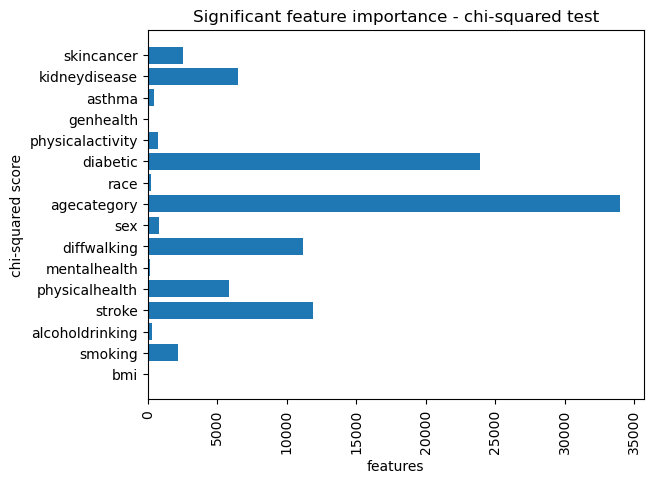

In [51]:
x = data_model.drop(columns = 'heartdisease')
y = data_model['heartdisease']
chi_scores, p_values = chi2(x, y)

important_features_chi = np.array(x.columns)[p_values < 0.05]

x_important = x[important_features_chi]

plt.barh(important_features_chi, chi_scores[p_values < 0.05], tick_label = important_features_chi)
plt.title('Significant feature importance - chi-squared test')
plt.xlabel('features')
plt.ylabel('chi-squared score')
plt.xticks(rotation = 90)
plt.savefig('Feature_Importance.jpeg')
plt.show()

In [52]:
print('Important features to consider are:', important_features_chi)

Important features to consider are: ['bmi' 'smoking' 'alcoholdrinking' 'stroke' 'physicalhealth'
 'mentalhealth' 'diffwalking' 'sex' 'agecategory' 'race' 'diabetic'
 'physicalactivity' 'genhealth' 'asthma' 'kidneydisease' 'skincancer']


Based on the results above, we neglected the sleeptime feature while building the model. 

## Check final dataset composition

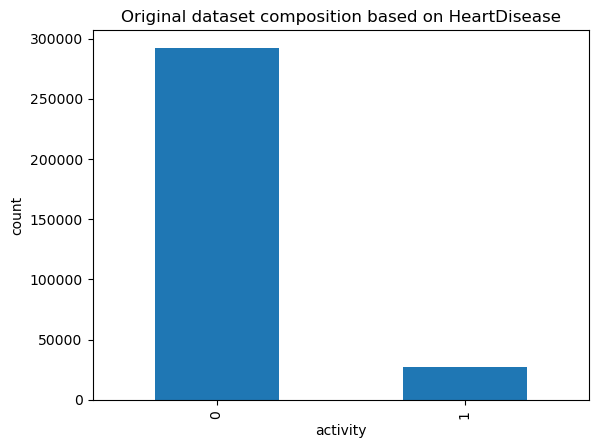

In [53]:
## Check df composition to make sure it is properly balanced
plt.title('Original dataset composition based on HeartDisease')
data_model['heartdisease'].value_counts().plot.bar()
plt.ylabel('count')
plt.xlabel('activity')
plt.savefig('HD_Composition.jpeg')
plt.show()

The dataset is highly unbalanced with the majority of the available data referring to people with no heart disease. Since the aim of this project is to develop a model able to predict the risk of being affected by heart disease or not based on the other available features, we balanced the dataset. To do that, we first oversampled the minority class (people with no heart disease) through SMOTE and then randomly selected an equal number of readings associated to people with and without heart disease. 

For this section, we followed the same procedure adopted in https://www.kaggle.com/code/soumendumandal/eda-handling-imbalance-feature-12-model-auc-0-99

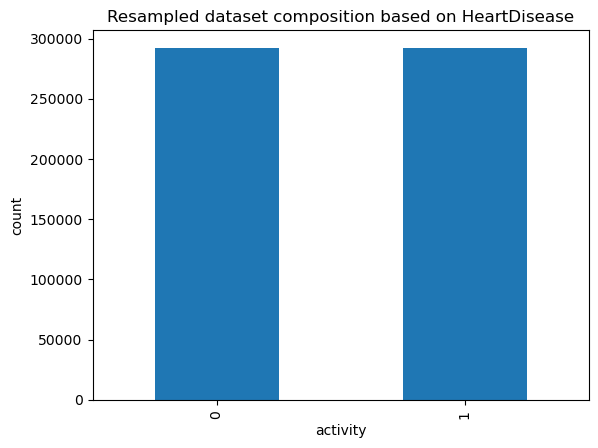

In [54]:
# SMOTE on df
smote = SMOTE(random_state = 42)
x_res, y_res = smote.fit_resample(x, y)

plt.title('Resampled dataset composition based on HeartDisease')
y_res.value_counts().plot.bar()
plt.ylabel('count')
plt.xlabel('activity')
plt.savefig('HD_Composition_Resampled.jpeg')
plt.show()

# Remove the sleeptime feature from x_resampled based on the chi-squared test results

For this section, we followed the same procedure adopted in https://www.kaggle.com/code/soumendumandal/eda-handling-imbalance-feature-12-model-auc-0-99

In [55]:
x_final = x_res[important_features_chi]
y_final = y_res
data_final = pd.concat([y_final, x_final], axis = 1)
data_final

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,asthma,kidneydisease,skincancer
0,0,0.055294,1,0,0,0.100000,1.00000,0,0,7,4,3,1,4,1,0,1
1,0,0.100447,0,0,1,0.000000,0.00000,0,0,12,4,0,1,4,0,0,0
2,0,0.175782,1,0,0,0.666667,1.00000,0,1,9,4,3,1,1,1,0,0
3,0,0.147169,0,0,0,0.000000,0.00000,0,0,11,4,0,0,2,0,0,1
4,0,0.141132,0,0,0,0.933333,0.00000,1,0,4,4,0,1,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584839,1,0.138515,0,0,0,0.000000,0.00000,0,1,12,2,3,1,2,0,0,0
584840,1,0.190646,0,0,0,0.000000,0.00000,0,1,11,4,0,1,4,0,0,0
584841,1,0.296320,0,0,0,0.670599,0.00000,1,0,10,4,0,0,1,1,0,0
584842,1,0.164796,0,0,0,0.000000,0.23786,0,0,5,1,0,1,4,0,0,0


## Data split in three sets, training, validation 

In [56]:
rand_split = np.random.rand(len(data_final))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
batch_list = rand_split >= 0.9

data_train = data_final[train_list]
data_val = data_final[val_list]
data_batch = data_final[batch_list].drop(["heartdisease"], axis = 1)

In [57]:
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name

bucket = sess.default_bucket()
prefix = "heart-disease-prediction-xgboost"
s3 = boto3.client("s3")

In [58]:
train_file = "train_data.csv"
data_train.to_csv(train_file, index = False, header = False)
sess.upload_data(train_file, key_prefix = "{}/train".format(prefix))

validation_file = "validation_data.csv"
data_val.to_csv(validation_file, index = False, header = False)
sess.upload_data(validation_file, key_prefix = "{}/validation".format(prefix))

batch_file = "batch_data.csv"
data_batch.to_csv(batch_file, index = False, header = False)
sess.upload_data(batch_file, key_prefix = "{}/batch".format(prefix))

's3://sagemaker-us-east-1-917612120297/heart-disease-prediction-xgboost/batch/batch_data.csv'

## Model creation

%%time

job_name = "xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)
image = sagemaker.image_uris.retrieve(
    framework = "xgboost", region = boto3.Session().region_name, version = "1.7-1"
)

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count = 1,
    instance_type = "ml.m5.xlarge",
    volume_size = 50,
    input_mode = "File",
    output_path = output_location,
    sagemaker_session = sess,
)

sm_estimator.set_hyperparameters(
    objective = "binary:logistic",
    max_depth = 6,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.8,
    verbosity = 0,
    num_round = 100,
)

train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train".format(bucket, prefix),
    distribution = "FullyReplicated",
    content_type = "text/csv",
    s3_data_type = "S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validation".format(bucket, prefix),
    distribution = "FullyReplicated",
    content_type = "text/csv",
    s3_data_type = "S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

sm_estimator.fit(inputs = data_channels, job_name = job_name, logs = True)

## Batch transform

%%time

sm_transformer = sm_estimator.transformer(1, "ml.m4.xlarge")

input_location = "s3://{}/{}/batch/{}".format(
    bucket, prefix, batch_file
)  
sm_transformer.transform(input_location, content_type = "text/csv", split_type = "Line")
sm_transformer.wait()

def get_csv_output_from_s3(s3uri, batch_file):
    file_name = "{}.out".format(batch_file)
    match = re.match("s3://([^/]+)/(.*)", "{}/{}".format(s3uri, file_name))
    output_bucket, output_prefix = match.group(1), match.group(2)
    s3.download_file(output_bucket, output_prefix, file_name)
    return pd.read_csv(file_name, sep = ",", header = None)

## Model results

predictions = get_csv_output_from_s3(sm_transformer.output_path, batch_file)
predicted = list(map(lambda x: 0 if x else 1, (predictions < 0.5).values))
true = data_final[batch_list]['heartdisease'].tolist()

# Confusion Matrix
cm = confusion_matrix(true, predicted)
cm_image = ConfusionMatrixDisplay(cm, display_labels = ['no heart disease', 'heart disease'])
cm_image.plot()

# Classification report
cr = classification_report(true, predicted)
print(cr)

# ROC AUC
roc_auc = roc_auc_score(true, predictions)
print('ROC-AUC score:', round(roc_auc, 2))

## Model creation with hyperparameter tuning

%%time

job_name = "xgb-hyperparameters-tuning" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)

sm_estimator_tuned = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count = 1,
    instance_type = "ml.m5.xlarge",
    volume_size = 50,
    input_mode = "File",
    output_path = output_location,
    sagemaker_session = sess,
)

sm_estimator_tuned.set_hyperparameters(
    objective = "binary:logistic",
    max_depth = 6,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.8,
    verbosity = 0,
    num_round = 100,
)

sm_estimator_tuner = HyperparameterTuner(estimator = sm_estimator_tuned, 
                                               objective_metric_name = 'validation:f1', 
                                               objective_type = 'Maximize', 
                                               max_jobs = 20, 
                                               max_parallel_jobs = 3, 
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'gamma': ContinuousParameter(0, 10),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
            
                                               })

sm_estimator_tuner.fit(inputs = data_channels)

sm_estimator_tuner.wait()

sm_estimator_tuner.best_training_job()

sm_estimator_tuned_attached = sagemaker.estimator.Estimator.attach(sm_estimator_tuner.best_training_job())

## Batch transform after tuning

%%time

sm_transformer_tuned = sm_estimator_tuned_attached.transformer(1, "ml.m4.xlarge")

sm_transformer_tuned.transform(input_location, content_type = "text/csv", split_type = "Line")
sm_transformer.wait()

## Model results after tuning

predictions_tuned = get_csv_output_from_s3(sm_transformer_tuned.output_path, batch_file)
predicted_tuned = list(map(lambda x: 0 if x else 1, (predictions_tuned < 0.5).values))

# Confusion Matrix
cm_tuned = confusion_matrix(true, predicted_tuned)
cm_image_tuned = ConfusionMatrixDisplay(cm_tuned, display_labels = ['no heart disease', 'heart disease'])
cm_image_tuned.plot()

# Classification report
cr_tuned = classification_report(true, predicted_tuned)
print(cr_tuned)

# ROC AUC
roc_auc_tuned = roc_auc_score(true, predictions_tuned)
print('ROC-AUC score:', round(roc_auc_tuned, 2))

## Upload the final sagemaker model created during our training job to the Sagemaker Model Registry

sagemaker = boto3.client("sagemaker")

model_name = "sagemaker-xgboost-240623-1417-020-4d514fbf"
print(model_name)

info = sagemaker.describe_training_job(TrainingJobName = model_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]

primary_container = {"Image": image, "ModelDataUrl": model_data}

create_model_response = sagemaker.create_model(
    ModelName = model_name, ExecutionRoleArn = role, PrimaryContainer = primary_container
)

print(create_model_response["ModelArn"])

## Create an endpoint configuration

endpoint_config_name = 'xgb-tuned-endpoint-config' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())                            
                            
instance_type = 'ml.c5.xlarge'

endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name, 
    ProductionVariants = [
        {
            "VariantName": "variant1", 
            "ModelName": model_name, 
            "InstanceType": instance_type, 
            "InitialInstanceCount": 1 
        }
    ]
)

print(f"Created EndpointConfig: {endpoint_config_response['EndpointConfigArn']}")

## Deploy model to real end point

endpoint_name = 'xgb-tuned-endpoint' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())                            


create_endpoint_response = sagemaker.create_endpoint(
                                            EndpointName = endpoint_name, 
                                            EndpointConfigName = endpoint_config_name) 

sagemaker.describe_endpoint(EndpointName = endpoint_name)

while True:
    print("Getting Job Status")
    res = sagemaker.describe_endpoint(EndpointName = endpoint_name)
    state = res["EndpointStatus"]
    
    if state == "InService":
        print("Endpoint in Service")
        break
    elif state == "Creating":
        print("Endpoint still creating...")
        sleep(60)
    else:
        print("Endpoint Creation Error - Check Sagemaker Console")
        break

## Invoke endpoint

sagemaker_runtime = boto3.client("sagemaker-runtime", region_name = region)

response = sagemaker_runtime.invoke_endpoint(
                            EndpointName = endpoint_name,
                            ContentType = 'text/csv',
                            Body = data_batch.to_csv(header = None, index = False).strip('\n').split('\n')[0]
                            )
print(response['Body'].read().decode('utf-8'))

info

## Set up model group

For this section, we followed the same procedure described in 

https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-model-group.html

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/describe_model_package_group.html

region = boto3.Session().region_name
role = get_execution_role()
sm_client = boto3.client('sagemaker', region_name = region)

model_package_group_name = "xgboost-heart-disease-detection" + str(round(time.time()))
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : "Predictive xgboost model to the likelihood of suffering from an heart disease based on 16 indicators."
}

create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

response = sm_client.describe_model_package_group(ModelPackageGroupName = model_package_group_name)

response

## Set up model package

For this section, we followed the same procedure described in 

https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/describe_model_package.html

sm_client.delete_model_package(ModelPackageName = "xgboost-heart-disease-detection-package")

model_package_name = "xgboost-heart-disease-detection-package"

modelpackage_inference_specification =  {
    "InferenceSpecification": {
        "Containers": [
            {
                'Image': image,
                'ModelDataUrl': model_data
            }
        ],
        "SupportedTransformInstanceTypes": [
            'ml.m4.xlarge'
        ],
        "SupportedRealtimeInferenceInstanceTypes": [
            'ml.m4.xlarge'
        ],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"],
    }
}

create_model_package_input_dict = {
    "ModelPackageName" : model_package_name,
    "ModelPackageDescription" : "Predictive xgboost model to the likelihood of suffering from an heart disease based on 16 indicators."
}
create_model_package_input_dict.update(modelpackage_inference_specification)

create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

response = sm_client.describe_model_package(ModelPackageName = model_package_name)

response

## Set up model card

For this section, we followed the same procedure described in 

https://docs.aws.amazon.com/sagemaker/latest/dg/model-cards-create.html

https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker/client/describe_model_card.html

sm_client.delete_model_card(ModelCardName = "xgboost-heart-disease-detection-card")

from sagemaker.model_card import (ModelOverview, ObjectiveFunction, Function, ObjectiveFunctionEnum, FacetEnum, TrainingDetails, IntendedUses, AdditionalInformation, ModelCardStatusEnum, ModelCard, MetricGroup, Metric, MetricTypeEnum, EvaluationJob, ModelPackage)

model_overview = ModelOverview.from_model_name(
model_name = model_name, 
sagemaker_session = sess,
model_description = "Predictive xgboost model to the likelihood of suffering from an heart disease based on 16 indicators.",
problem_type = "Binary classification", 
algorithm_type = "xgboost", 
model_creator = "Group 7",
model_owner = "Group 7",
)

print(model_overview.model_id)
print(model_overview.inference_environment.container_image)
print(model_overview.model_artifact)

objective_function = ObjectiveFunction(
    function = Function(
        function = ObjectiveFunctionEnum.MINIMIZE,
        facet = FacetEnum.LOSS,
    ),
    notes = "binary:logistic is the chosen objective function for the model.",
)

training_details = TrainingDetails.from_model_overview(
    model_overview = model_overview,
    sagemaker_session = sess,
    objective_function = objective_function,
    training_observations = "16 features are used as inputs for both training and inference. Here the list of these features: bmi, smoking, alcoholdrinking, stroke, physicalhealth, mentalhealth, diffwalking, sex, agecategory, race, diabetic, physicalactivity, genhealth, asthma, kidneydisease, skincancer.",
)

print(training_details.training_job_details.training_arn)
print(training_details.training_job_details.training_environment.container_image) 
print([{"name": i.name, "value": i.value} for i in training_details.training_job_details.training_metrics]) 

my_metric_group = MetricGroup(
name = "binary classification metrics",
metric_data = [Metric(name = "accuracy", type = MetricTypeEnum.NUMBER, value = 0.93)]
)

evaluation_details = [
    EvaluationJob(
        name = "Evaluation on batch data",
        datasets = ["ss3://sagemaker-us-east-1-917612120297/heart-disease-prediction-xgboost/batch/batch_data.csv"],
        metric_groups= [my_metric_group],
    )
]

intended_uses = IntendedUses(
purpose_of_model = "Model used to evaluate the risk to suffer from an heart disease in the future based on 16 features representing demographic and health information of the specific subject.",
intended_uses = "To be adopted by national health organizations to identify the most critical factors having an impact on the risk of health disease, thereby promoting future health initiatives to reduce that risk.",
)

additional_information = AdditionalInformation(
ethical_considerations = "Ethical considerations to be further explored.",
caveats_and_recommendations = "Further evaluations are necessary before using this model in a clinical setting.",
)

model_card_name = "xgboost-heart-disease-detection-card"
my_card = ModelCard(
    name = model_card_name,
    status = ModelCardStatusEnum.DRAFT,
    model_overview = model_overview,
    training_details = training_details,
    intended_uses = intended_uses,
    evaluation_details=evaluation_details,
    additional_information = additional_information,
    sagemaker_session = sess,
)
my_card.create()

response = sm_client.describe_model_card(
    ModelCardName = model_card_name
)

response

## Production data preparation

Data used for production were pre-processed by following the same steps applied to the dataset used for the final model creation. 

In [59]:
data_prod.head(10)

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer,origin
0,0,27.99,0,0,0,4.0,0.0,0,0,9,4,0,1,4,9.0,0,0,0,2022
1,0,30.13,0,0,0,0.0,0.0,0,1,10,4,3,1,4,6.0,0,0,0,2022
2,0,31.66,0,1,0,0.0,0.0,1,1,11,4,0,0,4,8.0,0,0,0,2022
3,0,31.32,0,0,0,5.0,0.0,1,0,12,4,0,1,1,9.0,0,0,1,2022
4,0,33.07,0,0,0,3.0,15.0,0,0,12,4,0,1,2,5.0,0,0,0,2022
5,0,34.96,0,1,0,0.0,0.0,0,1,6,4,0,1,2,7.0,0,0,0,2022
6,0,33.30,0,0,1,3.0,0.0,0,0,12,0,3,1,2,8.0,0,0,0,2022
7,0,24.37,0,0,0,5.0,0.0,0,1,11,4,3,1,1,8.0,0,0,1,2022
8,0,26.94,0,0,0,2.0,0.0,0,1,4,4,0,0,2,6.0,0,0,0,2022
9,0,22.60,0,0,0,0.0,0.0,0,0,11,4,0,1,4,7.0,1,0,1,2022


In [60]:
# data_prod = data_prod.drop(columns = ['origin', 'event_time'])
data_prod = data_prod.drop(columns = ['origin'])

In [61]:
data_prod[['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']] = scaler.fit_transform(data_prod[['bmi', 'physicalhealth', 'mentalhealth', 'sleeptime']])
data_prod

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,sleeptime,asthma,kidneydisease,skincancer
0,0,0.186500,0,0,0,0.133333,0.000000,0,0,9,4,0,1,4,0.347826,0,0,0
1,0,0.211491,0,0,0,0.000000,0.000000,0,1,10,4,3,1,4,0.217391,0,0,0
2,0,0.229359,0,1,0,0.000000,0.000000,1,1,11,4,0,0,4,0.304348,0,0,0
3,0,0.225388,0,0,0,0.166667,0.000000,1,0,12,4,0,1,1,0.347826,0,0,1
4,0,0.245825,0,0,0,0.100000,0.500000,0,0,12,4,0,1,2,0.173913,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,0,0.236599,0,1,0,0.000000,0.000000,0,1,8,4,0,1,4,0.217391,0,0,0
246018,0,0.143875,0,0,0,0.000000,0.233333,0,0,1,0,0,1,1,0.260870,0,0,0
246019,0,0.208338,0,1,1,0.000000,0.500000,0,1,9,2,3,1,2,0.260870,0,0,0
246020,0,0.194324,0,0,0,0.066667,0.066667,0,0,6,0,0,1,0,0.260870,0,0,0


In [62]:
x_prod = data_prod.drop(columns = 'heartdisease')
y_prod = data_prod['heartdisease']

In [63]:
x_prod_res, y_prod_res = smote.fit_resample(x_prod, y_prod)

In [64]:
x_prod_final = x_prod_res[important_features_chi]
y_prod_final = y_prod_res
data_prod_final = pd.concat([y_prod_final, x_prod_final], axis = 1)
data_prod_final

,heartdisease,bmi,smoking,alcoholdrinking,stroke,physicalhealth,mentalhealth,diffwalking,sex,agecategory,race,diabetic,physicalactivity,genhealth,asthma,kidneydisease,skincancer
0,0,0.186500,0,0,0,0.133333,0.000000,0,0,9,4,0,1,4,0,0,0
1,0,0.211491,0,0,0,0.000000,0.000000,0,1,10,4,3,1,4,0,0,0
2,0,0.229359,0,1,0,0.000000,0.000000,1,1,11,4,0,0,4,0,0,0
3,0,0.225388,0,0,0,0.166667,0.000000,1,0,12,4,0,1,1,0,0,1
4,0,0.245825,0,0,0,0.100000,0.500000,0,0,12,4,0,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470887,1,0.268190,1,1,0,0.036097,0.652848,0,0,5,4,0,0,2,0,0,0
470888,1,0.212634,0,1,0,0.000000,0.000000,0,1,5,0,0,1,2,0,0,0
470889,1,0.119482,1,1,0,0.000000,0.791776,0,1,3,4,0,1,1,0,0,0
470890,1,0.218796,0,1,0,0.000000,0.000000,0,1,3,1,0,1,4,0,0,0
